# __CENTRACK__ 

This pipeline accepts a 16bit CxWxH tiff file.

1. It extracts the DAPI channel and blurs, contours them.
1. It extracts a centriole marker (user input) and threshold it and extract the local maxima that are a given minimal distance.
1. It assigns each centriole to the nearest nucleus (assumption that the nucleus is in the image)
1. It saves intermediary images to help in case of bugs
1. It writes an ontology file with the nucleus coordinates and the associated centrioles coordinates.

In [7]:
import cv2
from pathlib import Path
import tifffile as tf
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats

from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

import operator
from pprint import pprint

from centrack import image_8bit_contrast

In [8]:
# Create directory variables
path_root = Path('/Volumes/work/datasets/')
# RPE1wt_CEP63+CETN2+PCNT_1
# "RPE1wt_CEP152+GTU88+PCNT_1"
dataset_name = input("Enter the name of a dataset")

path_projections = path_root / dataset_name / 'projected'

# Collect the ome.tiff files
files = sorted(tuple(file for file in path_projections.iterdir() 
                     if file.name.endswith('.tif') 
                     if not file.name.startswith('.')))
pprint([file.name for file in files])

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/work/datasets/projected'

In [5]:
file_path = files[1]
data = tf.imread(file_path)
data.shape

NameError: name 'files' is not defined

In [30]:
# data = tf.imread('/Volumes/work/datasets/RPE1wt_CEP63+CETN2+PCNT_1/projected/gfp-1_patch.tif')
# data = np.expand_dims(data, 0)

In [6]:
data_bgr = data[0:3, :, :]
data_bgr = np.moveaxis(data_bgr, 0, -1)
data_bgr_8bit = image_8bit_contrast(data_bgr)

cv2.imwrite(f'./out/{file_path.stem}_0_dapi+markers_16bit.png', data_bgr);
cv2.imwrite(f'./out/{file_path.stem}_0_dapi+markers_8bit.png', data_bgr_8bit);

## Segment the nuclei

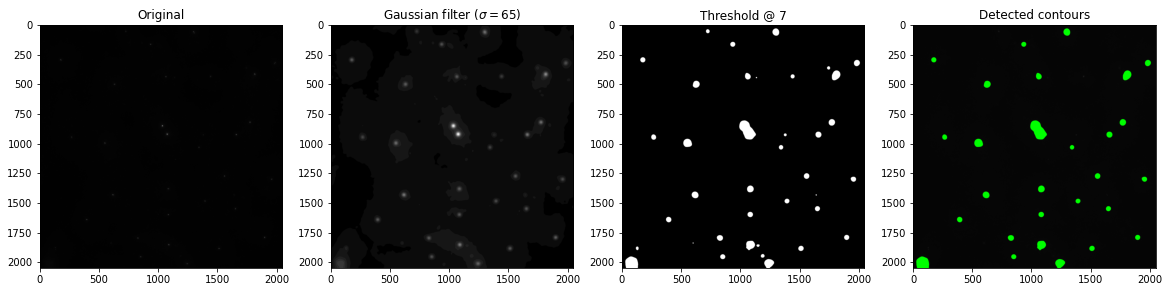

In [53]:
# Extract the DAPI channel
nuclei = data[0, :, :]

# Apply the gaussian blurring filter with large kernel (1/16 of the image width)
image_w, image_h = nuclei.shape[-2:]
kernel_size = image_w // 32 + 1

nuclei_8bit = cv2.convertScaleAbs(nuclei, alpha=255/nuclei.max())
blurred = cv2.GaussianBlur(nuclei_8bit, (kernel_size, kernel_size), 0)

# Threshold the image
threshold_mode = cv2.THRESH_BINARY + cv2.THRESH_OTSU
ret, nuclei_thresh = cv2.threshold(blurred, 0, 255, threshold_mode)

# Find the contours
contours, hierarchy = cv2.findContours(nuclei_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours_nuclei = [cnt for cnt in contours if cv2.contourArea(cnt) > 1000]

nuclei_8bit_bgr = cv2.cvtColor(nuclei_8bit, cv2.COLOR_GRAY2BGR)
nuclei_annotated = cv2.drawContours(nuclei_8bit_bgr, contours_nuclei, -1, (0, 255, 0), cv2.FILLED)

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].imshow(nuclei, 'gray')
axs[0].set_title('Original')
axs[1].imshow(blurred, 'gray')
axs[1].set_title(f'Gaussian filter ($\sigma={kernel_size}$)')
axs[2].imshow(nuclei_thresh, 'gray')
axs[2].set_title(f'Threshold @ {ret:.0f}')
axs[3].imshow(nuclei_annotated)
axs[3].set_title(f'Detected contours');

cv2.imwrite(f'./out/{file_path.stem}_1_nuclei.png', nuclei_annotated);

## Detect the centrioles

In [7]:
channel = int(input("Which channel number?") or 1)

Which channel number? 0


Enter the kernel size (3) 
Enter the minimal distance between two foci (2) 
Enter the 16bit threshold for centriole (1000) 250


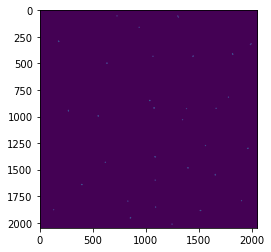

In [11]:
# Extract the appropriate channel
centrioles = data[channel, :, :]
kernel_size = int(input("Enter the kernel size (3)") or 3)
distance_min = int(input("Enter the minimal distance between two foci (2)") or 2)
threshold_foci = int(input("Enter the 16bit threshold for centriole (1000)") or 500)

centrioles_8bit = image_8bit_contrast(centrioles)
cv2.imwrite(f'./out/{file_path.stem}_2_centrioles.png', 
            cv2.bitwise_not(centrioles_8bit));

centrioles[centrioles < threshold_foci] = 0

# centrioles = cv2.GaussianBlur(centrioles, (kernel_size, kernel_size), 0)

centrioles_float = img_as_float(centrioles.copy())
foci_coords = peak_local_max(centrioles_float, min_distance=distance_min)

for r, c in foci_coords:
    cv2.drawMarker(centrioles_8bit, (c, r), 255, cv2.MARKER_CROSS, 10)
    
plt.imshow(centrioles_8bit)

cv2.imwrite(f'./out/{file_path.stem}_2_centrioles_peaks_T{threshold_foci}.png', cv2.bitwise_not(centrioles_8bit));

## Assign centrioles to the nearest nucleus

In [168]:
contours_nearest = []

for c, centriole in enumerate(foci_coords):
    r_c, c_c = centriole

    distance_to_nuclei = []
    
    for n, nucleus in enumerate(contours_nuclei):
        dist = cv2.pointPolygonTest(nucleus, (c_c, r_c), True)
        distance_to_nuclei.append((c, n, int(abs(dist))))
        
    contours_nearest.append(min(distance_to_nuclei, key=operator.itemgetter(-1)))

In [169]:
annotation_layer = np.zeros_like(nuclei_8bit)
structures = np.zeros_like(nuclei_8bit_bgr)

for el in contours_nearest:
    cent_id, nucl_id, dist = el
    
    if abs(dist) > 200:
        print('orphan', dist)
        continue
    
    r_c, c_c = foci_coords[cent_id]
    nucleus = contours_nuclei[nucl_id]
    
    M = cv2.moments(nucleus)
    
    r_n, c_n = int(M['m01']/M['m00']), int(M['m10']/M['m00'])
    
    centriole_centre = (c_c, r_c)
    nucleus_centre = (c_n, r_n)
    
    cv2.drawMarker(annotation_layer, centriole_centre, 255, cv2.MARKER_CROSS) # centrioles cv2.MARKER_CROSS
    cv2.circle(annotation_layer, (c_n, r_n), 10, 255, -1) # nuclei
    cv2.arrowedLine(annotation_layer, centriole_centre, nucleus_centre, 255, 2) # assignment

# cv2.addWeighted(annotation_layer, alpha, nuclei_bgr, alpha, 0, final)
structures[:, :, 0] = nuclei_8bit
structures[:, :, 1] = annotation_layer
structures[:, :, 2] = centrioles_8bit
cv2.imwrite(f'./out/{file_path.stem}_3_assigned.png', structures);